In [ ]:
from sample_complexity_utils import evaluate_one_estimator_torch
from concurrent.futures import ProcessPoolExecutor
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run_sample_complexity_study_torch_parallel(
        true_theta_np,
        d=5,
        num_init_trajs=10,
        jump_size=2,
        num_increments=10,
        num_repeat=20,
        learning_rate=0.001,
        num_epochs=1000,
        batch_size=32,
        max_workers=4  # you control # of parallel jobs here
    ):
    traj_sizes = [num_init_trajs * (jump_size ** i) for i in range(num_increments)]
    l2_errors, max_errors, log_likelihoods = [], [], []

    for k in tqdm(traj_sizes, desc="Trajectory sizes"):
        kwargs_list = [
            {
                "k": k,
                "d": d,
                "true_theta_np": true_theta_np,
                "learning_rate": learning_rate,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "seed": np.random.randint(0, 1e6)
            }
            for _ in range(num_repeat)
        ]

        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(evaluate_one_estimator_torch, kwargs_list))

        l2s, maxs, lls = zip(*results)
        l2_errors.append((np.mean(l2s), np.std(l2s)))
        max_errors.append((np.mean(maxs), np.std(maxs)))
        log_likelihoods.append((np.mean(lls), np.std(lls)))

    return traj_sizes, l2_errors, max_errors, log_likelihoods

def plot_with_ci(x, means_and_stds, ylabel, title, save=False):
    means = np.array([mean for mean, std in means_and_stds])
    stds = np.array([std for mean, std in means_and_stds])

    lower = means - 1.96 * stds
    upper = means + 1.96 * stds

    plt.figure(figsize=(6, 4))
    plt.plot(x, means, label="Mean", color="blue")
    plt.fill_between(x, lower, upper, color="blue", alpha=0.2, label="95% CI")
    plt.xlabel("Number of Trajectories")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figs/{ylabel}.png", dpi=300) if save else None
    plt.show()



In [7]:
d = 3
true_theta_np = np.random.uniform(0.2, 0.8, size=(1,d))

traj_sizes, l2s, maxs, lls = run_sample_complexity_study_torch_parallel(
    true_theta_np=true_theta_np,
    d=d,
    num_init_trajs=10,
    jump_size=2,
    num_increments=15,
    num_repeat=20,
    learning_rate=0.001,
    num_epochs=1000,
    batch_size=8,
    max_workers=12,
)

Trajectory sizes:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# save results

with open("sample_complexity_results.pkl", "wb") as f:
    pickle.dump((traj_sizes, l2s, maxs, lls), f)

# # load results
# with open("sample_complexity_results.pkl", "rb") as f:
#     traj_sizes, l2s, maxs, lls = pickle.load(f)

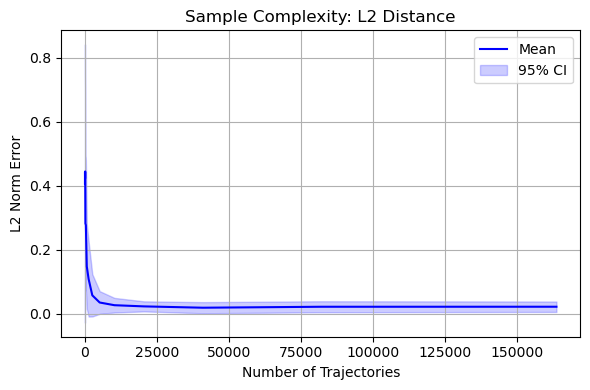

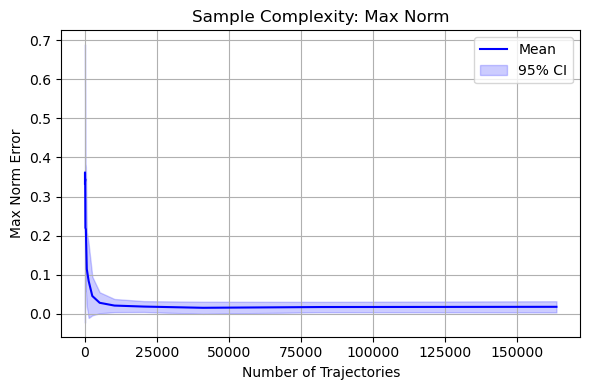

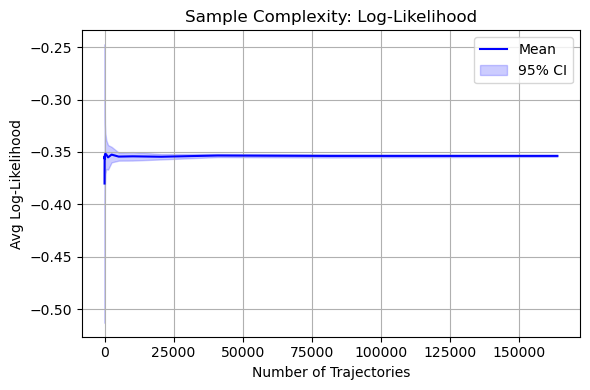

In [ ]:
plot_with_ci(traj_sizes, l2s, "L2 Norm Error", "Sample Complexity: L2 Distance", save=True)
plot_with_ci(traj_sizes, maxs, "Max Norm Error", "Sample Complexity: Max Norm", save=True)
plot_with_ci(traj_sizes, lls, "Avg Log-Likelihood", "Sample Complexity: Log-Likelihood", save=True)